<a href="https://colab.research.google.com/github/DrAlexSanz/nlp-demystified/blob/main/Fake_news_detection_log_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import spacy.cli
spacy.cli.download("en_core_web_lg") # For the vectors

from google.colab import drive

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


## Import data
Easier to download from kaggle and upload to my drive in this case

In [4]:
raw_train = pd.read_csv("/content/drive/MyDrive/Datasets/fake_news/train.csv")
raw_test = pd.read_csv("/content/drive/MyDrive/Datasets/fake_news/test.csv") # Test dataset is to send to kaggle originally. I don't need this here.
raw_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


### See if the dataset is balanced

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0831a0fac0>]],
      dtype=object)

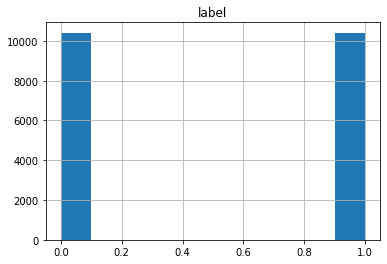

In [5]:
raw_train.hist(column = "label")
# 1 is fake/unreliable. 0 is ok news.

### See if I can find a writer that always writes good/fake news.
* That admin guy is dangerous!

In [6]:
# Start with fakes
fakes = raw_train[raw_train["label"] == 1]

fakes = fakes[["id", "author"]]
authors = fakes.groupby(by = "author").agg("nunique")
authors.reset_index(inplace = True)
authors = authors.sort_values(by = "id", ascending = False)
authors.head()


,author,id
1710,admin,193
1213,Pakalert,86
526,Eddy Lavine,85
1474,Starkman,84
634,Gillian,82


In [7]:
# Now do good news
good = raw_train[raw_train["label"] == 0]

good = good[["id", "author"]]
authors = good.groupby(by = "author").agg("nunique")
authors.reset_index(inplace = True)
authors = authors.sort_values(by = "id", ascending = False)
authors.head()

,author,id
1732,Pam Key,242
949,Jerome Hudson,166
387,Charlie Spiering,141
997,John Hayward,140
1156,Katherine Rodriguez,124


## Now let's take the text and the label only. I don't care about the rest of the data

In [8]:
train = raw_train[["text", "label"]]
x = raw_train["text"]
y = raw_train["label"]

x_train, y_train, x_test, y_test = train_test_split(x, y, test_size = 0.1) # Limit the tf idf memory consumption by reducing the train size. Not smart but it works


## Clean the text with Spacy.

Remove whatever is not a word and tokenize it.

In [25]:
nlp = spacy.load('en_core_web_lg') # This one has vectors. The en_core_web_sm doesn't

# This is my tokenization function

def spacy_tokenizer(doc):
  # use .lemma_ instead of .text to reduce memory footprint
  transformed = [t.text for t in nlp(doc) if \
                not t.is_space and \
                not t.is_stop and \
                t.is_alpha]

  return transformed

# If I try to do a TfIdf it will run out of memory

There are about 40K articles. I will have a minimum of 10K words in my vocabulary. That alone is a matrix with 40K x 10K elements = 400 M. Even if it's stored as a sparse matrix, while creating it, it's dense at some point and it takes more than 16 GB memory.

The solution is word embeddings.

In [27]:
# First tokenize some words to check and see if everything works correctly
test_sent = spacy_tokenizer(x[0])
test_sent[:13]

['House',
 'Dem',
 'Aide',
 'Comey',
 'Letter',
 'Jason',
 'Chaffetz',
 'Tweeted',
 'Darrell',
 'Lucus',
 'October',
 'Subscribe',
 'Jason']

In [42]:
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
